# Explauto, an open-source Python library to study autonomous exploration in developmental robotics

Explauto is an open-source Python library providing a unified API to design and compare various exploration strategies driving various sensorimotor learning algorithms in various simulated or robotics systems. Explauto aims at being collaborative and pedagogic, providing a platform to developmental roboticists where they can publish and compare their algorithmic contributions related to autonomous exploration and learning, as well a platform for teaching and scientific diffusion. It is is available on [github](https://github.com/flowersteam/explauto).

The library is organized in three main packages, each one containing a collection of interchangeable modules:
* The [environment package](http://flowersteam.github.io/explauto/explauto.environment.html) provides a unified interface to real and simulated robots.
* The [sensorimotor_model package](http://flowersteam.github.io/explauto/explauto.sensorimotormodel.html) provides a unified interface to online machine learning algorithm.
* The [interest_model package](http://flowersteam.github.io/explauto/explauto.interestmodel.html) provides a unified interface for the active choice of sensorimotor experiments.

The library is easily extendable by forking the [github repository](https://github.com/flowersteam/explauto) and proposing new modules for each package (tutorial to come, do not hesitate to [contact us](https://github.com/flowersteam/explauto/blob/master/AUTHORS.md) want to get involved).

This tutorial shows how to use modules contained in these three packages, how to integrated them in simulation loops and how to analyse the results.

## Setting environments

In Explauto, an *environment* implements the physical properties of the interaction between the robot body and the environment in which it evolves. Explauto comes with several sensorimotor systems available from the [environment package](http://flowersteam.github.io/explauto/explauto.environment.html):

In [18]:
from explauto.environment import environments
environments.keys()

['pypot', 'pendulum', 'simple_arm']

According to your installation, you will see at least two available environments:
* a multi-joint arm acting on a plan ('simple_arm')
* an under-actuated torque-controlled circular pendulum  ('pendulum').

These environments are simulated. Explauto also provides an interface to real robots based on Dynamixel actuators by providing bindings to the [Pypot](https://github.com/poppy-project/pypot) library  ([this tutorial](http://nbviewer.ipython.org/github/flowersteam/explauto/blob/master/notebook/poppy_environment.ipynb) shows how to use it on a [Poppy](http://www.poppy-project.org/) robot).

We will use the simple arm for this tutorial. It consists in the simulation of a $n$ degrees-of-freedom (DoF) arm with movements limited to a 2D plan. Each available environment comes with a set of predefined configurations. A default configuration will always be defined. For the simple arm they are:

In [19]:
from explauto.environment import available_configurations
available_configurations('simple_arm').keys()

['mid_dimensional',
 'default',
 'high_dim_high_s_range',
 'low_dimensional',
 'high_dimensional']

For example, the 'mid_dimensional' configuration corresponds to:

In [20]:
available_configurations('simple_arm')['mid_dimensional']

{'length_ratio': 1.5,
 'm_maxs': array([ 1.04719755,  1.04719755,  1.04719755,  1.04719755,  1.04719755,
         1.04719755,  1.04719755]),
 'm_mins': array([-1.04719755, -1.04719755, -1.04719755, -1.04719755, -1.04719755,
        -1.04719755, -1.04719755]),
 'noise': 0.02,
 's_maxs': array([ 1.,  1.]),
 's_mins': array([-0.5, -1. ])}

One can use this method with every registered environments. For example the available configurations for the pendulum are:

In [21]:
available_configurations('pendulum').keys()

['default', 'underactuated']

Let's instantiate a mid-dimensional simple arm:

In [22]:
from explauto import Environment
environment = Environment.from_configuration('simple_arm', 'mid_dimensional')

Each particular environment has to implement its own  [compute_sensori_effect](http://flowersteam.github.io/explauto/explauto.environment.html#explauto.environment.environment.Environment.compute_sensori_effect) method, which takes as argument a motor command vector $m$ (here the position of the joints, 7-dimensional). It returns the corresponding sensory effect vector $s$ (here the coordinate of the hand, $2$-dimensional).

In [23]:
from numpy import pi
m = [-pi/6., pi/3., pi/4., pi/5., 0., pi/3., pi/6.]
environment.compute_sensori_effect(m)

array([ 0.4154867 ,  0.27653954])

Environments can implement specific methods for, e.g., drawing:

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


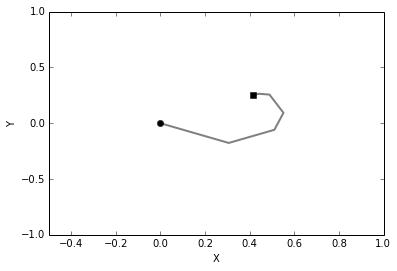

In [24]:
# Create the axes for plotting::
%pylab inline
ax = axes()

# plot the arm:
environment.plot_arm(ax, m)

The base of the arm is fixed at (0, 0) (circle). The first angle position m[0] corresponds to the angle between a horizontal line and the segment attached to the base, anticlock-wise. Each following angle position is measured with respect to their respective previous segment. 

The [Environment](http://flowersteam.github.io/explauto/explauto.environment.html#explauto.environment.environment.Environment) base class provides several useful methods in order to, e.g., sample random motor commands:

In [25]:
motor_configurations = environment.random_motors(n=10)

Let's for example plot 10 random arm configurations:

Populating the interactive namespace from numpy and matplotlib


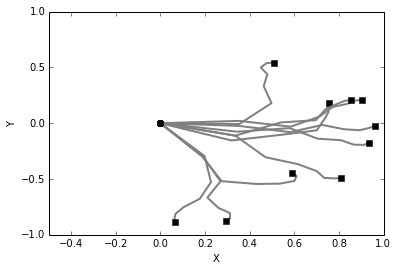

In [26]:
# Create the axes for plotting::
%pylab inline
ax = axes()

# Plotting 10 random motor configurations:
for m in motor_configurations:
    environment.plot_arm(ax, m)

Dynamical environments are also available, though their integration with the rest of the library is not yet completly clear (to discuss later). E.g., a circular pendulum:

In [27]:
environment = Environment.from_configuration('pendulum', 'default')

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


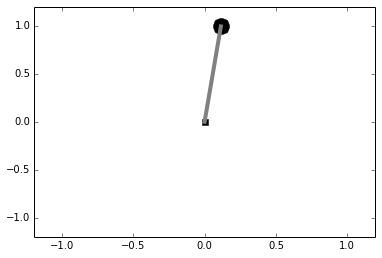

In [28]:
%pylab
ax = axes()

# Sequence of torques at each time step:
U = [0.25] * 15 + [-0.25] * 15 + [0.25] * 19

# reset to lower position:
environment.reset() 

# apply torque and plot:
for u in U:
    ax.cla()
    environment.apply_torque(u)
    environment.plot_current_state(ax)
    draw()

The [compute_sensori_effect](http://flowersteam.github.io/explauto/explauto.environment.html#explauto.environment.environment.Environment.compute_sensori_effect) method is also defined (using a motor primitive):

In [29]:
environment.compute_sensori_effect(environment.random_motors())

array([ 2.46355812,  3.1644856 ])

But let's continue this tutorial using a mid-dimensional simple arm:

In [30]:
environment = Environment.from_configuration('simple_arm', 'mid_dimensional')

## Learning sensorimotor models

In Explauto, a sensorimotor model implements both the iterative learning process from sensorimotor experience, i.e. from the iterative collection of $(m, s)$ pairs by interaction with the environment, and the use of the resulting internal model to perform forward and inverse predictions (or any kind of general prediction between sensorimotor subspaces). 

Learning sensorimotor mappings involves machine learning algorithms, for which Explauto provides a unified interface through the [SensorimotorModel abstract class](http://flowersteam.github.io/explauto/explauto.sensorimotormodel.html#explauto.sensorimotor_model.sensorimotor_model.SensorimotorModel). 

Using the simple arm environment above, it allows to iteratively learn a sensorimotor model which will be able to:
* infer the position of the end-effector from a given motor command, what is called *forward prediction*,
* infer the motor command allowing to reach a particular end-effector position, what is called *inverse prediction*.
* update online from sensorimotor experience


Several sensorimotor models are provided: simple nearest-neighbor look-up, non-parametric models combining classical regressions and optimization algorithms, online local mixtures of Gaussians (ILO-GMM and IMLE), and discrete Lindstone distributions.
Similarly to environments, available sensorimotor models in Explauto can be accessed using:

In [31]:
from explauto.sensorimotor_model import sensorimotor_models
sensorimotor_models.keys()

['ilo_gmm', 'LWLR-CMAES', 'WNN', 'NN', 'LWLR-BFGS']

Here we will use the 'nearest_neighbor' model. This sensorimotor model simply stores sensorimotor experience, ie. $(m, s)$ pairs where $m$ is a motor command (here arm joint positions) and $s$ the corresponding sensory effect (here end-effector positions). When asked for a forward prediction for a given motor command $m$, it returns the associated sensory effect $s$ of the nearest neighbor of $m$ in the stored sensorimotor experience. When asked for an inverse prediction to reach a sensory goal $s$, it returns the associated motor command $m$ of the nearest neighbor of $s$ in the stored sensorimotor experience, possibly pertubated with a bit gaussian noise.

In [32]:
from explauto.sensorimotor_model import available_configurations
available_configurations('NN')

{'default': {'fwd': 'NN', 'inv': 'NN', 'sigma_explo_ratio': 0.1}}

We will use the 'exact' configuration, which perform forward and inverse prediction as explained above, without any noise added (ie., it just looks for the nearest neighbor). 

Now we can instantiate the sensorimotor model by using:

In [33]:
from explauto import SensorimotorModel
sm_model = SensorimotorModel.from_configuration(environment.conf, 'NN', 'default')

Note that in addition to the names of the model and its configuration, one also has to pass environment.conf. This a [Configuration](http://flowersteam.github.io/explauto/explauto.utils.html#explauto.utils.config.Configuration) object which is instantiated during the environment creation and provides information about the motor and sensorimotor ranges used by the environment. It is useful for the sensorimotor model to be properly configured. When using the 'default' configuration for example, the added noise when performing inverse prediction depends on the motor ranges. Passing environment.conf thus allows to define sensorimotor model configurations independently of particular environment settings.

Now let's train the model from the execution of random motor commands (i.e. random motor babbling):

In [34]:
for m in environment.random_motors(n=1000):
    # compute the sensori effect s of the motor command m through the environment:
    s = environment.compute_sensori_effect(m)
    # update the model according to this experience:
    sm_model.update(m, s)

Note that sensorimotor model training in Explauto is an iterative process. They incorporate new sensorimotor experience on the fly instead of using batch training. This is a requirement for autonomous exploration where the internal model has to be refined *online*.

Once the sensorimodel has been trained, one can perform forward and inverse prediction with it. Let's predict the sensori effect of a new random motor command (which is not in the training set we just used) using the [forward_prediction](http://flowersteam.github.io/explauto/explauto.sensorimotormodel.html#explauto.sensorimotor_model.sensorimotor_model.SensorimotorModel.forward_prediction) method:

In [35]:
# random motor command:
m = environment.random_motors(n=1)[0]
# predicted sensory effect:
s_pred = sm_model.forward_prediction(m)

print 'random motor command: ', m
print 'predicted effect: ', s_pred

random motor command:  [ 0.11746958 -0.5011052  -0.71633104  0.02443131 -0.73668964  0.37236439
  0.49024322]
predicted effect:  [ 0.83868946 -0.3310619 ]


and compare the predicted effect with the real effect observed from executing $m$ through the environment:

Populating the interactive namespace from numpy and matplotlib


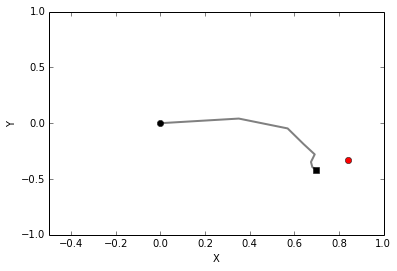

In [36]:
%pylab inline
ax = axes()

environment.plot_arm(ax, m)
ax.plot(*s_pred, marker='o', color='red')

We observe that the predicted end-effector position is quite close to the observed position when executing the motor command. Using the 'nearest_neighbor' model, it simply corresponds to the sensory effect of the nearest neighbor of $m$ in the stored sensorimotor experience.

Sensorimotor models can also be used for inverse prediction using the [inverse_prediction](http://flowersteam.github.io/explauto/explauto.sensorimotormodel.html#explauto.sensorimotor_model.sensorimotor_model.SensorimotorModel.inverse_prediction) method, allowing the inference of an appropriate motor comand $m$ in order to reach a given sensory goal $s_g$:

In [37]:
s_g = [0.7, 0.5]
m = sm_model.inverse_prediction(s_g)
print 'Inferred motor command to reach the position ', s_g, ': ', m

Inferred motor command to reach the position  [0.7, 0.5] :  [-0.13158603  0.63558849  0.22086358  0.15832117 -0.70975276  0.68070173
  0.30240378]


We can check if the inferred motor command is actually appropriate to reach the goal $s_g$:

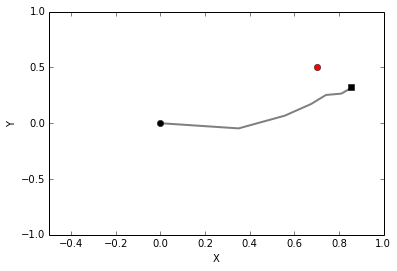

In [38]:
ax = axes()
environment.plot_arm(ax, m)
ax.plot(*s_g, marker='o', color='red')

We observe that the inferred motor command results in an end-effector position which is quite close to the goal. Using the 'exact' configuration of the 'nearest_neighbor' model, it is simply the motor command which resulted in the sensory effect which is the closest to $s_g$ in the stored experience.

Here is a bit more complex example where the arm attempt to follow a vertical straight line with the end-effector:

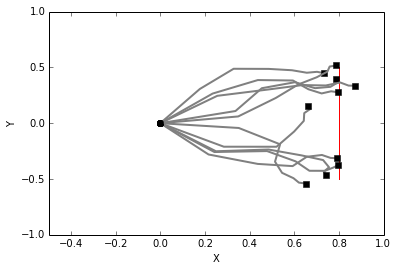

In [39]:
ax = axes()

# Define the line and plot it:
x = 0.8
y_a = 0.5
y_b = -0.5
ax.plot([x, x], [y_a, y_b], color='red')

# for 10 points equidistantly spaced on the line, perform inverse prediction and plot:
for y in linspace(-0.5, 0.5, 10):
    m = sm_model.inverse_prediction([x, y])
    environment.plot_arm(ax, m)

Using another sensorimotor model in Explauto simply consists of changing the model name and configuration above. For example, you can try to execute the exact same code, just replacing the model instanciation by:

In [40]:
sm_model = SensorimotorModel.from_configuration(environment.conf, 'ilo_gmm', 'default')

## Motor and goal babbling using interest models

In Explauto, the role of interest models is to provide sensorimotor predictions (forward or inverse) to be performed by the sensorimotor model. An interest model implements the active exploration process,  where sensorimotor experiments are chosen to improve the forward or inverse predictions of the sensorimotor model. It explores in a given *interest space* resulting in motor babbling strategies when it corresponds to the motor space and in goal babbling strategies when it corresponds to the sensory space.

An interest model has to implement a sampling procedure in the interest space. Explauto provides several sampling procedures: 
* random sampling
* learning progress maximization in forward or inverse predictions.
* In development:
    * social interaction (e.g. using a mouse pointer to interactively provide sensory goals)
    * optimization toward a specific goal

Similarly to environments and sensorimotor models, available interest models in Explauto can be accessed using:

In [41]:
from explauto.interest_model import interest_models, available_configurations
interest_models.keys()

['discretized_progress', 'tree', 'random', 'gmm_progress_beta']

and the available configurations of a given model by:

In [42]:
available_configurations('discretized_progress')

{'default': {'measure': <function explauto.interest_model.competences.competence_dist>,
  'win_size': 10,
  'x_card': 400}}

Using an environment, a sensorimotor and an interest model, one can run a motor babbling strategy by:
* first instantiate a random motor interest model:

In [43]:
from explauto import InterestModel
im_model = InterestModel.from_configuration(environment.conf, environment.conf.m_dims, 'random')

* Then running the following simulation loop and (optionally) plotting the reached sensory effects:

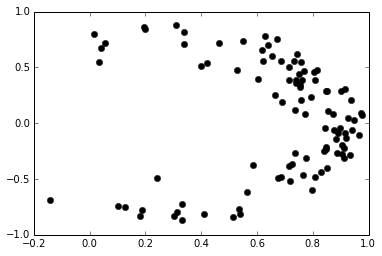

In [44]:
# re-instantiate the sensorimotor model (to forget what was previously learnt in the previous section
sm_model = SensorimotorModel.from_configuration(environment.conf, 'NN', 'default')

# run the simulation loop
for _ in range(100):
    # sample a random motor command using the interest model:
    m = im_model.sample()
    # execute this command and observe the corresponding sensory effect:
    s = environment.compute_sensori_effect(m)
    # update the sensorimotor model:
    sm_model.update(m, s)
    im_model.update(hstack((m, s)), hstack((m, s_g)))
    # plot the observed sensory effect:
    plot(s[0], s[1], 'ok')

(The plots are quite hugly here, we will present Explauto visualization tools in the following.)

Random goal babbling corresponds to:

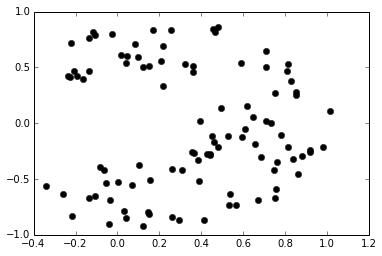

In [45]:
# Instantiate a random goal interest model:
im_model = InterestModel.from_configuration(environment.conf, environment.conf.s_dims, 'random')

for _ in range(100):
    # sample a random sensory goal using the interest model:
    s_g = im_model.sample()
    # infer a motor command to reach that goal using the sensorimotor model:
    m = sm_model.inverse_prediction(s_g)
    # execute this command and observe the corresponding sensory effect:
    s = environment.compute_sensori_effect(m)
    # update the sensorimotor model:
    sm_model.update(m, s)
    # plot the observed sensory effect:
    plot(s[0], s[1], 'ok')

We observe that goal babbling allow a more uniform covering of the sensory space.

And finally, here is the code for curiosity-driven goal babbling (maximization of the learning progress):

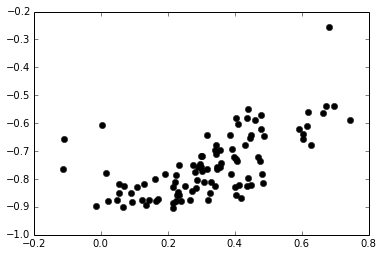

In [46]:
# Instantiate an active goal interest model:
im_model = InterestModel.from_configuration(environment.conf, environment.conf.s_dims, 'discretized_progress')

for _ in range(100):
    # sample a sensory goal maximizing learning progress using the interest model:
    s_g = im_model.sample()
    # infer a motor command to reach that goal using the sensorimotor model:
    m = sm_model.inverse_prediction(s_g)
    # execute this command and observe the corresponding sensory effect:
    s = environment.compute_sensori_effect(m)
    # update the sensorimotor model:
    sm_model.update(m, s)
    # update the interest model:
    im_model.update(hstack((m, s)), hstack((m, s_g)))
    # plot the observed sensory effect:
    plot(s[0], s[1], 'ok')

The reached point obtained above do not well cover the sensory space. This is due to the fact that we did not re-initialize the sensorimotor model (therefore this latter was already trained) to avoid some bootstrapping issues. The next section shows how to encapsulate a sensorimotor and an interest models into an agent to, among other things, take care of those bootstrapping issues.

## Encapsulating a sensorimotor and an interest models into an agent

Encapsulating a sensorimotor and an interest models into an agent allows to generalize and simplify the simulation loop whatever the exploration strategy involved, ie whatever the type of babbling, the sensorimotor and the interest models. In Explauto, an agent is intantiated using a configuration (generally from an environment), a sensorimotor and an interest models:

In [47]:
from explauto import Agent

sm_model = SensorimotorModel.from_configuration(environment.conf, 'NN', 'default')
im_model = InterestModel.from_configuration(environment.conf, environment.conf.m_dims, 'random')

agent = Agent(environment.conf, sm_model, im_model)

An agent is provided with two methods. One for producing a motor command:

In [48]:
m = agent.produce()
print m

[-0.70326572  0.2160142   0.49817111  0.01863247  0.68811851  0.14562944
  0.27005644]


The *produce()* method calls the *sample()* method of the interest model, which returns either a motor command or a sensory goal according to the interest space (i.e. the type of babbling). Then it uses the sensorimotor model to complete the obtained value into a full sensorimotor vector (using forward prediction in case of motor babbling and inverse prediction in case of goal babbling). Finally it returns the motor part of this full sensorimotor vector. Agents also take care of model bootstrapping issues.

The second main agent method is *perceive()*, which informs the agent with the sensorimotor consequence of its action in order to update both the sensorimotor and the interest models:

In [49]:
s = environment.update(m)
agent.perceive(s)

Hence the entire simulation loop can now be rewritten as:

In [50]:
for _ in range(100):
    m = agent.produce()
    s = environment.update(m)
    agent.perceive(s)    

This loop is valid whatever the exploration strategy involved. The corresponding formal framework is defined in:

C. Moulin-Frier and P.-Y. Oudeyer, [*Exploration strategies in developmental robotics: A unified probabilistic framework*](https://hal.inria.fr/hal-00860641), ICDL/Epirob, Osaka, Japan, 2013, pp. 1–6.


Let's for example create a curiosity-driven goal babbler:

In [51]:
sm_model = SensorimotorModel.from_configuration(environment.conf, 'NN', 'default')
im_model = InterestModel.from_configuration(environment.conf, environment.conf.s_dims, 'discretized_progress')

agent = Agent(environment.conf, sm_model, im_model)

and run it using the exact same loop:

In [52]:
for _ in range(100):
    m = agent.produce()
    s = environment.update(m)
    agent.perceive(s)

Of course lack a way to visualize the result of our simulations here, this is why we introduce Explauto's Experiment in the next section.

## Encapsulating an environment and an agent into an experiment

Encapsulating an environment and an agent into an experiment allows to evaluate agent learning and offers plotting facilities. Once an environment and an agent have been constructed, one can set an experiment using:

In [53]:
from explauto import Experiment

expe = Experiment(environment, agent)

An experiment offers the management of the simulation loop with evaluation, logging and plotting capabilities. Instead of seperately constructing the environment and the agent (containing the sensorimotor and the interest models), one can simply use:

In [54]:
from explauto.experiment import make_settings

random_goal_babbling = make_settings(environment='simple_arm', environment_config = 'mid_dimensional',
                                     babbling_mode='goal', 
                                     interest_model='random',
                                     sensorimotor_model='NN')

expe = Experiment.from_settings(random_goal_babbling)

This is the compact way to construct the environment (here a mid-dimensional 'simple_arm'), the sensorimotor model (here, 'nearest_neighbor') and the interest model (here curiosity-driven goal babbling) and encapsulate them into an experiment.

An experiment allows to insert an evaluation phase at given time steps:

In [55]:
expe.evaluate_at([100, 200, 400, 1000], random_goal_babbling.default_testcases)

Now let's run the experiment:

In [56]:
expe.run()

This executes the same simulation loop as above, inserting an evaluation phase at each specified time step and logging the flow of interest model choices, sensorimotor model inferences and sensorimotor observations. This allows to, e.g., visualize the chosen goals and reached hand positions during the experiment using the [scatter_plot](http://flowersteam.github.io/explauto/explauto.experiment.html#explauto.experiment.log.ExperimentLog.scatter_plot) method:

Populating the interactive namespace from numpy and matplotlib


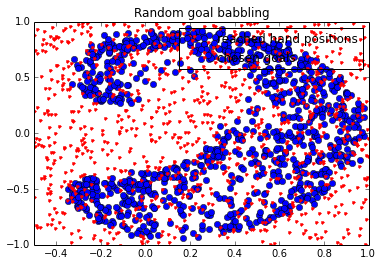

In [57]:
%pylab inline
ax = axes()
title(('Random goal babbling'))

expe.log.scatter_plot(ax, (('sensori', [0, 1]),))
expe.log.scatter_plot(ax, (('choice', [0, 1]),), marker='.', color='red')
#expe.log.scatter_plot(ax, (('testcases', [0, 1]),), marker='o', color='green')

legend(['reached hand positions', 'chosen goals'])

or to vizualize the learning curve:

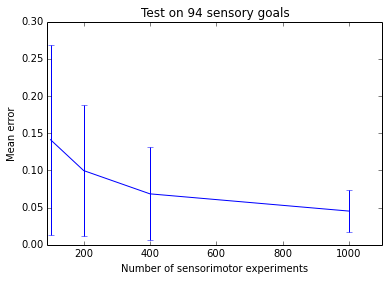

In [58]:
ax = axes()
expe.log.plot_learning_curve(ax)

## Parallel comparison of exploration strategies

Various exploration strategies can be launched in parallel and compared by using an experiment pool:

In [59]:
from explauto import ExperimentPool
xps = ExperimentPool.from_settings_product(environments=[('simple_arm', 'high_dim_high_s_range')],
                                           babblings=['goal'],
                                           interest_models=[('random', 'default'), ('discretized_progress', 'default')],
                                           sensorimotor_models=[('NN', 'default')],
                                           evaluate_at=[200, 500, 900, 1400],
                                           same_testcases=True)

running it:

In [60]:
xps.run()

array([[<explauto.experiment.log.ExperimentLog object at 0x7f60e95ec150>],
       [<explauto.experiment.log.ExperimentLog object at 0x7f60e95ecf50>]], dtype=object)

comparing learning curves:

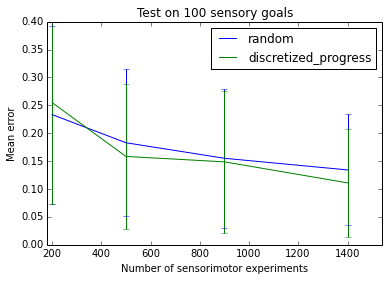

In [61]:
ax = axes()

for log in xps.logs:
    log.plot_learning_curve(ax)
    
legend([s.interest_model for s in xps.settings])

or vizualize the iterative choice of goals and the reached effects:

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


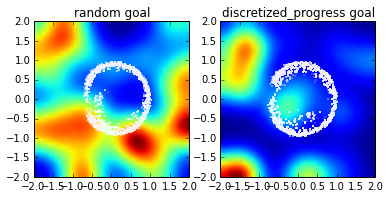

In [62]:
%pylab
clf()
last_t = 0
for t in linspace(100, xps.logs[0].eval_at[-1], 40):
    t = int(t)
    for i, (config, log) in enumerate(zip(xps.settings, xps.logs)):
        ax = subplot(1, 2, i+1)
        log.scatter_plot(ax, (('sensori', [0, 1]),), range(0, t), marker='.', markersize=0.3, color = 'white')
        log.density_plot(ax, (('choice', [0, 1]),), range(last_t, t))
        title(config.interest_model + ' ' + config.babbling_mode)
        draw()
    last_t = t

## Work in progress

* Interest models for social interaction
* Motor and sensory primitives, eg Dynamic Movement Primitives
    * in open and close loop modes
* Module connexion for modularity and graphical programming    